In [1]:
# Import necessary modules

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt

In [16]:
def train_linear_regression(X, y):
    """
    Train a Linear Regression model and return the trained model and R² score.
    """
    reg = LinearRegression()
    reg.fit(X, y)
    r2_score = reg.score(X, y)
    return reg, r2_score

def plot_true_vs_predicted(y_true, y_pred, xlabel, ylabel, title, diag_range):
    """
    Generate a scatter plot comparing true vs. predicted values.
    
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - xlabel, ylabel: Axis labels
    - title: Plot title
    - diag_range: Tuple (min, max) for diagonal reference line
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='#2a9d8f', alpha=0.7, edgecolors='k')
    plt.plot(diag_range, diag_range, linestyle='dashed', color='#f4a261')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=18)
    plt.show()

def execute_gcm_regression(X, y, xlabel, ylabel, title, diag_range):
    """
    Train and plot results for GCM regression.
    
    Parameters:
    - X: Predictor variables (PC_GCM)
    - y: Target variable (e.g., PC_Str, PC_Htr, etc.)
    - xlabel, ylabel: Axis labels
    - title: Plot title
    - diag_range: Tuple for diagonal reference line
    """
    model, r2 = train_linear_regression(X, y)
    print(f"{title} R² Score: {r2:.4f}")
    plot_true_vs_predicted(y, model.predict(X), xlabel, ylabel, title, diag_range)

def perform_f_regression(X, y):
    """
    Compute F-statistics for feature selection and return sorted feature indices.
    """
    f_statistic, _ = f_regression(X, y)
    return np.argsort(f_statistic)  # Return indices sorted by feature importance

def select_top_features(X, feature_groups, sorted_indices):
    """
    Select the most significant feature from each predefined feature group.
    """
    selected_indices = {}

    for group, indices in feature_groups.items():
        selected = [i for i in sorted_indices if i in indices]
        if selected:  # Ensure there's a valid selection
            selected_indices[group] = selected[-1]  # Pick most significant feature
        else:
            print(f"Warning: No valid feature found for group {group}")

    return selected_indices

def extract_selected_features(X, selected_indices):
    """
    Extract feature columns based on selected feature indices.
    """
    return X[:, list(selected_indices.values())]

def print_selected_feature_names(X, selected_indices):
    """
    Print the names of the selected features for each feature group.
    """
    for group, index in selected_indices.items():
        print(f"Top {group} Feature: {X.columns[index]}")
    

In [3]:
# Read data file
df_PC = pd.read_csv('Plastic_Crystal_data_final.csv', encoding='latin-1')

# Load Features
PC_GCM = df_PC.iloc[:,9:37]
PC_SYM = df_PC.iloc[:,37:43]
PC_H = df_PC.iloc[:,44:50]
PC_R = df_PC.iloc[:,51:54]
PC_SVI = df_PC.iloc[:,54:57]
PC_EDA = df_PC.iloc[:,57:62]

# Load Properties
PC_Str = df_PC.iloc[:,5]
PC_Htr = df_PC.iloc[:,6]
PC_Tm = df_PC.iloc[:,8]
PC_year = df_PC.iloc[:,64]
PC_Ttr = df_PC.iloc[:,7]

Structural_descriptors = pd.concat([PC_SYM, PC_H, PC_R, PC_SVI, PC_EDA],axis=1)
scaler = MinMaxScaler()
Structural_descriptors_scaled = scaler.fit_transform(Structural_descriptors)

GCM Entropy Linear Regression R² Score: 0.7684


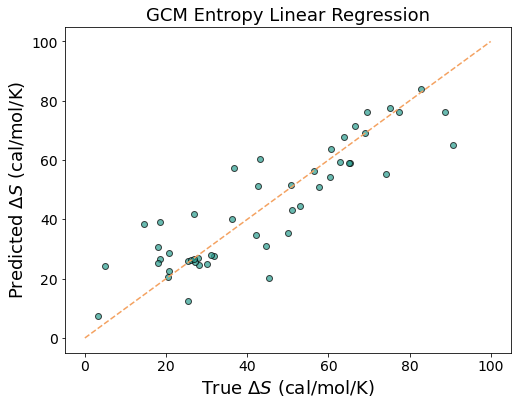

GCM Enthalpy Linear Regression R² Score: 0.8572


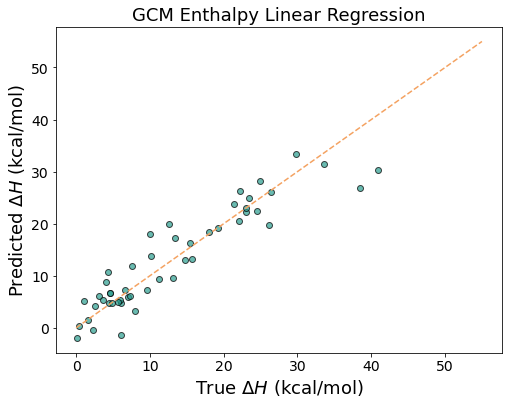

GCM Transition Temperature Linear Regression R² Score: 0.9348


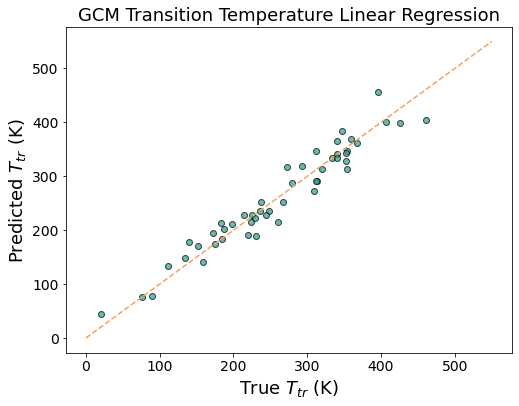

GCM Melting Temperature Linear Regression R² Score: 0.9360


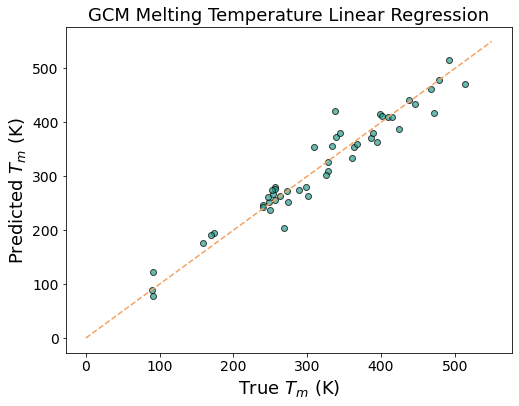

In [4]:
# Execute GCM Regression for different properties
execute_gcm_regression(PC_GCM, PC_Str, 
                       xlabel='True $\Delta S$ (cal/mol/K)', 
                       ylabel='Predicted $\Delta S$ (cal/mol/K)', 
                       title='GCM Entropy Linear Regression', 
                       diag_range=(0, 100))

execute_gcm_regression(PC_GCM, PC_Htr, 
                       xlabel='True $\Delta H$ (kcal/mol)', 
                       ylabel='Predicted $\Delta H$ (kcal/mol)', 
                       title='GCM Enthalpy Linear Regression', 
                       diag_range=(0, 55))

execute_gcm_regression(PC_GCM, PC_Ttr, 
                       xlabel='True $T_{tr}$ (K)', 
                       ylabel='Predicted $T_{tr}$ (K)', 
                       title='GCM Transition Temperature Linear Regression', 
                       diag_range=(0, 550))

execute_gcm_regression(PC_GCM, PC_Tm, 
                       xlabel='True $T_{m}$ (K)', 
                       ylabel='Predicted $T_{m}$ (K)', 
                       title='GCM Melting Temperature Linear Regression', 
                       diag_range=(0, 550))


Full Model R² Score: 0.8030


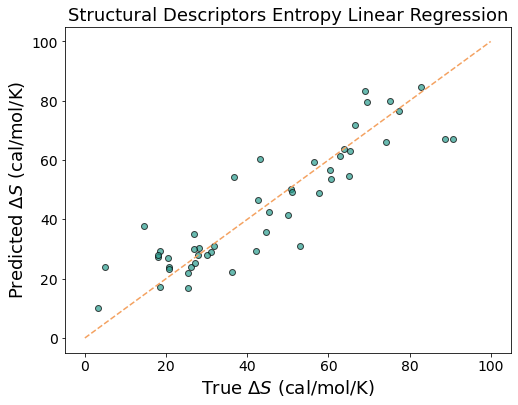

Top SYM Feature: distavg
Top H Feature: sumacc
Top R Feature: Svib(J/mol/K)
Top SVI Feature: Interaction Energy(kJ/mol)
Top EDA Feature: E_dispersion(kJ/mol)
Selected Features Model R² Score: 0.7070


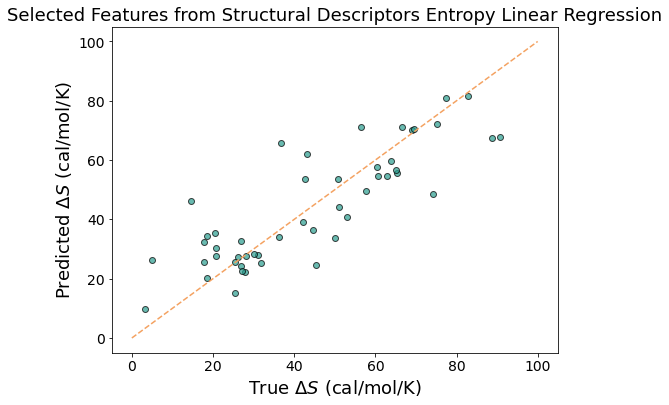

In [18]:
# Train a model on all structural descriptors
full_model, full_r2 = train_linear_regression(Structural_descriptors_scaled, PC_Str)
print(f"Full Model R² Score: {full_r2:.4f}")

# Plot full model predictions
plot_true_vs_predicted(PC_Str, full_model.predict(Structural_descriptors_scaled),
                       xlabel='True $\Delta S$ (cal/mol/K)', 
                       ylabel='Predicted $\Delta S$ (cal/mol/K)', 
                       title = 'Structural Descriptors Entropy Linear Regression',
                       diag_range=(0, 100))

# Perform feature selection using F-statistics
sorted_feature_indices = perform_f_regression(Structural_descriptors_scaled, PC_Str)

# Define feature groups
feature_groups = {
    "SYM": list(range(0, 6)),
    "H": list(range(6, 14)),
    "R": list(range(14, 17)),
    "SVI": list(range(17, 20)),
    "EDA": list(range(20, 25))
}

# Select the most important feature from each group
selected_features = select_top_features(Structural_descriptors_scaled, feature_groups, sorted_feature_indices)

# Extract selected feature data
selected_feature_data = extract_selected_features(Structural_descriptors_scaled, selected_features)

# Print selected feature names
print_selected_feature_names(Structural_descriptors, selected_features)

# Train a model on selected features
selected_model, selected_r2 = train_linear_regression(selected_feature_data, PC_Str)
print(f"Selected Features Model R² Score: {selected_r2:.4f}")

# Plot selected features model predictions
plot_true_vs_predicted(PC_Str, selected_model.predict(selected_feature_data),
                       xlabel='True $\Delta S$ (cal/mol/K)', 
                       ylabel='Predicted $\Delta S$ (cal/mol/K)', 
                       title = 'Selected Features from Structural Descriptors Entropy Linear Regression',
                       diag_range=(0, 100))

Full Model R² Score: 0.8440


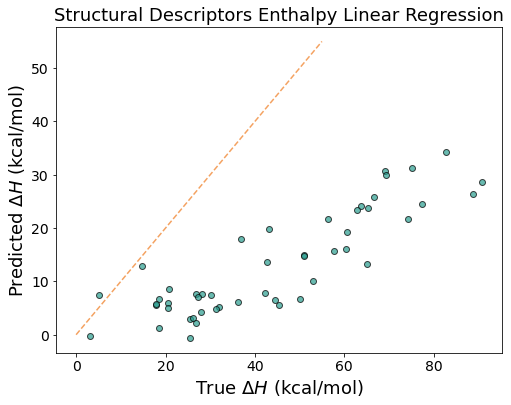

Top SYM Feature: distavg
Top H Feature: sumacc
Top R Feature: Svib(J/mol/K)
Top SVI Feature: Interaction Energy(kJ/mol)
Top EDA Feature: E_CT(kJ/mol)
Selected Features Model R² Score: 0.7624


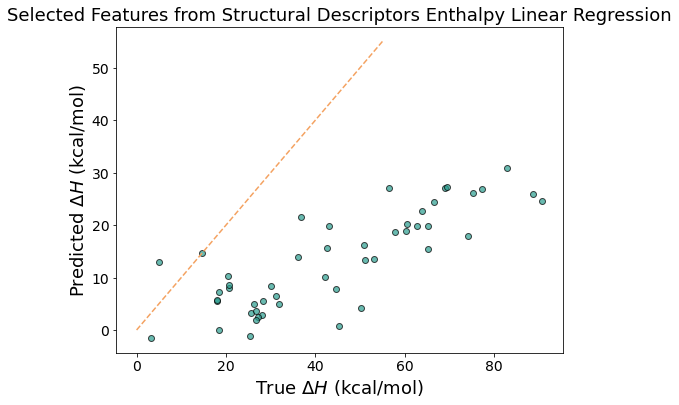

In [19]:
# Train a model on all structural descriptors
full_model, full_r2 = train_linear_regression(Structural_descriptors_scaled, PC_Htr)
print(f"Full Model R² Score: {full_r2:.4f}")

# Plot full model predictions
plot_true_vs_predicted(PC_Str, full_model.predict(Structural_descriptors_scaled),
                       xlabel='True $\Delta H$ (kcal/mol)', 
                       ylabel='Predicted $\Delta H$ (kcal/mol)', 
                       title = 'Structural Descriptors Enthalpy Linear Regression',
                       diag_range=(0, 55))

# Perform feature selection using F-statistics
sorted_feature_indices = perform_f_regression(Structural_descriptors_scaled, PC_Htr)


# Select the most important feature from each group
selected_features = select_top_features(Structural_descriptors_scaled, feature_groups, sorted_feature_indices)

# Extract selected feature data
selected_feature_data = extract_selected_features(Structural_descriptors_scaled, selected_features)

# Print selected feature names
print_selected_feature_names(Structural_descriptors, selected_features)

# Train a model on selected features
selected_model, selected_r2 = train_linear_regression(selected_feature_data, PC_Htr)
print(f"Selected Features Model R² Score: {selected_r2:.4f}")

# Plot selected features model predictions
plot_true_vs_predicted(PC_Str, selected_model.predict(selected_feature_data),
                       xlabel='True $\Delta H$ (kcal/mol)', 
                       ylabel='Predicted $\Delta H$ (kcal/mol)',  
                       title = 'Selected Features from Structural Descriptors Enthalpy Linear Regression',
                       diag_range=(0, 55))

Full Model R² Score: 0.8893


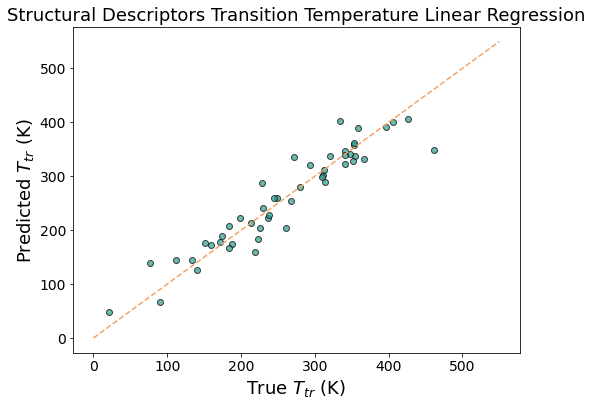

Top SYM Feature: distavg
Top H Feature: sumacc
Top R Feature: Svib(J/mol/K)
Top SVI Feature: Interaction Energy(kJ/mol)
Top EDA Feature: E_CT(kJ/mol)
Selected Features Model R² Score: 0.8036


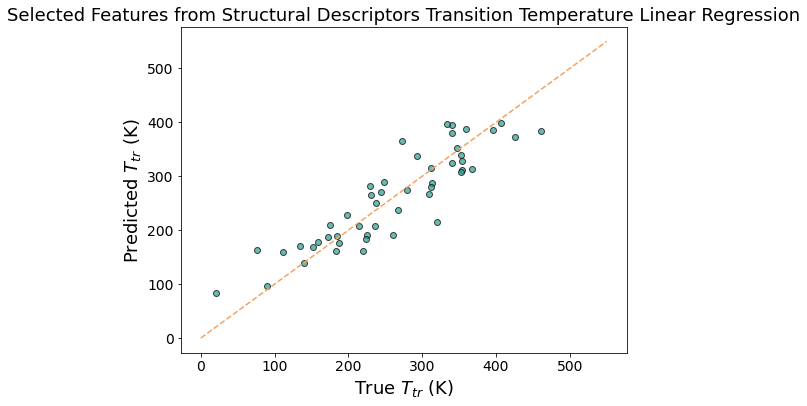

In [22]:
# Train a model on all structural descriptors
full_model, full_r2 = train_linear_regression(Structural_descriptors_scaled, PC_Ttr)
print(f"Full Model R² Score: {full_r2:.4f}")

# Plot full model predictions
plot_true_vs_predicted(PC_Ttr, full_model.predict(Structural_descriptors_scaled),
                       xlabel='True $T_{tr}$ (K)', 
                       ylabel='Predicted $T_{tr}$ (K)',  
                       title = 'Structural Descriptors Transition Temperature Linear Regression',
                       diag_range=(0, 550))

# Perform feature selection using F-statistics
sorted_feature_indices = perform_f_regression(Structural_descriptors_scaled, PC_Ttr)

# Select the most important feature from each group
selected_features = select_top_features(Structural_descriptors_scaled, feature_groups, sorted_feature_indices)

# Extract selected feature data
selected_feature_data = extract_selected_features(Structural_descriptors_scaled, selected_features)

# Print selected feature names
print_selected_feature_names(Structural_descriptors, selected_features)

# Train a model on selected features
selected_model, selected_r2 = train_linear_regression(selected_feature_data, PC_Ttr)
print(f"Selected Features Model R² Score: {selected_r2:.4f}")

# Plot selected features model predictions
plot_true_vs_predicted(PC_Ttr, selected_model.predict(selected_feature_data),
                       xlabel='True $T_{tr}$ (K)', 
                       ylabel='Predicted $T_{tr}$ (K)', 
                       title = 'Selected Features from Structural Descriptors Transition Temperature Linear Regression',
                       diag_range=(0, 550))

Full Model R² Score: 0.8914


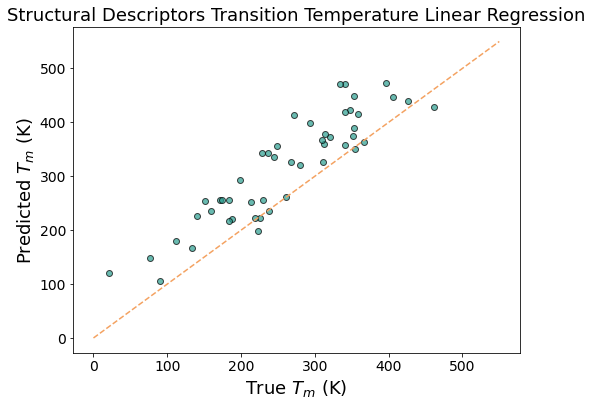

Top SYM Feature: distavg
Top H Feature: sumdon
Top R Feature: Svib(J/mol/K)
Top SVI Feature: Interaction Energy(kJ/mol)
Top EDA Feature: E_CT(kJ/mol)
Selected Features Model R² Score: 0.7747


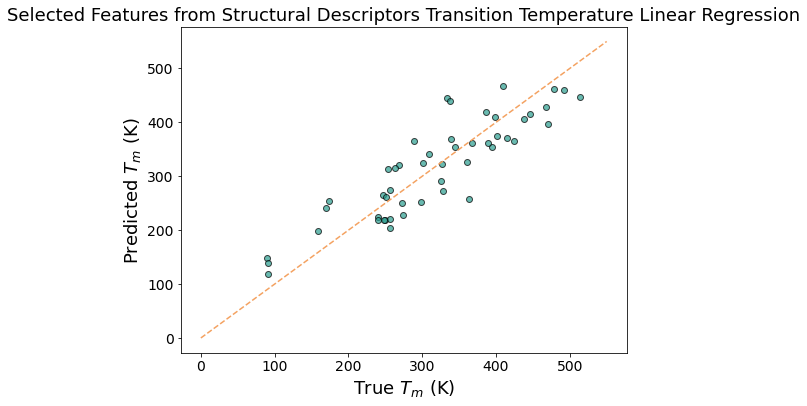

In [24]:
# Train a model on all structural descriptors
full_model, full_r2 = train_linear_regression(Structural_descriptors_scaled, PC_Tm)
print(f"Full Model R² Score: {full_r2:.4f}")

# Plot full model predictions
plot_true_vs_predicted(PC_Ttr, full_model.predict(Structural_descriptors_scaled),
                       xlabel='True $T_{m}$ (K)', 
                       ylabel='Predicted $T_{m}$ (K)',  
                       title = 'Structural Descriptors Transition Temperature Linear Regression',
                       diag_range=(0, 550))

# Perform feature selection using F-statistics
sorted_feature_indices = perform_f_regression(Structural_descriptors_scaled, PC_Tm)

# Select the most important feature from each group
selected_features = select_top_features(Structural_descriptors_scaled, feature_groups, sorted_feature_indices)

# Extract selected feature data
selected_feature_data = extract_selected_features(Structural_descriptors_scaled, selected_features)

# Print selected feature names
print_selected_feature_names(Structural_descriptors, selected_features)

# Train a model on selected features
selected_model, selected_r2 = train_linear_regression(selected_feature_data, PC_Tm)
print(f"Selected Features Model R² Score: {selected_r2:.4f}")

# Plot selected features model predictions
plot_true_vs_predicted(PC_Tm, selected_model.predict(selected_feature_data),
                       xlabel='True $T_{m}$ (K)', 
                       ylabel='Predicted $T_{m}$ (K)', 
                       title = 'Selected Features from Structural Descriptors Transition Temperature Linear Regression',
                       diag_range=(0, 550))